In [1]:
# Imports
%matplotlib inline

import sys
import numpy as np
import scipy
import scipy.stats as stats
from scipy.stats import binom
import matplotlib
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns
import math
from skmultiflow.drift_detection.adwin import ADWIN
# more info about skmultiflow library here:
#>> https://scikit-multiflow.github.io/scikit-multiflow/_autosummary/skmultiflow.drift_detection.ADWIN.html#skmultiflow.drift_detection.ADWIN.set_params

sns.set_style('darkgrid')
np.random.seed(4)

In [2]:
# Create static reward history

N_ARMS = 4
N_ROUNDS = 5
N_AGENTS = 5

rewardDistr = {}

def createreward(n,e):
    rewardHistory = []
    for j in range(e):
        reward = []
        for i in range(n):
            reward.append(np.random.randint(1,100)/100)
        rewardHistory.append(reward)
    return rewardHistory

for i in range(N_AGENTS):
    rewardDistr['Agent' + str(i+1)] = createreward(N_ARMS,N_ROUNDS)
    
print(rewardDistr['Agent1'])

[[0.47, 0.56, 0.7, 0.02], [0.88, 0.73, 0.51, 0.1], [0.59, 0.95, 0.56, 0.56], [0.58, 0.37, 0.51, 0.45], [0.39, 0.53, 0.04, 0.01]]


In [3]:
class Agent:
    def __init__(self, name, T, distribution, rewdis, time_variation):
        self.name = name
        self.T = T #total amount of iterations
        self.R_history = {}
        self.R_history[0] = rewdis[0] #
        self.rewdis = rewdis
        self.expectations = {}
        self.n_arms = len(self.rewdis[0])
        self.distribution = distribution #typology of distribution: Bernoulli | Gaussian
        self.N = np.zeros(self.n_arms) #number of times an arm has been pulled
        self.U = np.ones(self.n_arms) #upper bound for each arm
        self.r = [[] for i in range(self.n_arms)]
        self.cum_r = np.zeros(self.n_arms) #summation of all the reward retrieved
        self.hat_R = np.zeros(self.n_arms) #estimation of the reward, simple average
        self.B = np.zeros(self.n_arms) #confidence bound of each arm
        self.ind = [] #keep tracks of the indices of the selected arm for each iteration
        self.rewards = np.zeros(self.T) #keep track of the reward for each iteration
        self.R_T = np.zeros(self.T) #keep track of the regret
        self.arms_label = ['arm_'+str(i) for i in range(1,self.n_arms+1)] #arms label used to plot charts
        self.UB = [] #UCB1 upper bound, Auer and Cesa-Bianchi
        self.time_variation = time_variation
        self.adaptive_win = dict((k, ADWIN()) for k in range(self.n_arms))
        
    def get_current_R(self):
        return self.R_history[max(self.R_history)]
        
    def compute_upper_bound(self,t):
        R = self.get_current_R()
        delta = np.array( [max(R)] *  (self.n_arms)) - np.array(R)
        delta = delta[np.nonzero(delta)]
        self.UB.append(8 * sum(1 / delta) * np.log(t+1) + (1 + np.pi**2/3) * sum(delta))
    
    def compute_RB(self, t):
        i = self.ind[t]
        self.hat_R[i] = sum(self.r[i])/self.N[i]
        for i in range(self.n_arms):
            #variance = max(0.01,stats.pvariance(self.r[i]))
            self.B[i] = np.sqrt(2 * np.log(t+1) / self.N[i])
    
    def compute_windowed_RB(self, t, w):
        i = self.ind[t]
        if(self.N[i] == 0):
            self.hat_R[i] = sum(self.r[i])/self.N[i]
        elif(self.N[i] < w):
            self.hat_R[i] = np.mean(self.r[i])
        else:
            self.hat_R[i] = np.mean(self.r[i][-w:])
        for i in range(self.n_arms):
            #variance = max(0.1,stats.pvariance(self.r[i]))
            self.B[i] = np.sqrt(2 * np.log(t+1) / self.N[i])
    
    def compute_adaptive_windowed_RB(self, t):
        i = self.ind[t]
        self.adaptive_win[i].add_element(self.rewards[t])
        if self.adaptive_win[i].detected_change():
            print('Change detected in arm: ' + str(i) + ' - at iteration: ' + str(t))     
        self.hat_R[i] = self.adaptive_win[i].estimation
        for i in range(self.n_arms):
            #variance = max(0.1,stats.pvariance(self.r[i]))
            self.B[i] = np.sqrt(2 * np.log(t+1) / self.N[i])
    
    def compute_weighted_RB(self, t, alpha=None):
        i = self.ind[t]
        
        if(alpha == None):
            variance = max(0.1,stats.pvariance(self.r[i]))
            alpha = self.N[i] / (self.N[i]+(variance*10))
        weight = [alpha**j for j in range(int(self.N[i]))]
        if(len(weight)==0):
            self.hat_R[i] = sum(self.r[i])/self.N[i]
        else:
            self.hat_R[i] = np.average(self.r[i],weights=weight[::-1])
            
        for i in range(self.n_arms):
            #variance = max(0.1,stats.pvariance(self.r[i]))
            self.B[i] = np.sqrt(2 * np.log(t+1) / self.N[i])
        
    
    def change_reward(self,t):
        reward = []
        R = self.get_current_R()
        for i in range(self.n_arms):
            if(self.time_variation == 'step'):
                reward = self.rewdis[int((t+1)/200)]
                #reward.append(np.random.randint(1,100)/100)
            elif(self.time_variation == 'pos_log'):
                reward.append( min(1, R[i] + ((np.log(t+1))/(100*np.log(self.T)))) )
            elif(self.time_variation == 'neg_log'):
                reward.append( R[i] - ((np.log(t+1))/(2*np.log(self.T))) )
        self.R_history[t] = reward
    
    def generate_one_sample(self, pulled_arm):
        R = self.get_current_R()
        if (self.distribution == 'Binomial'):
            return np.random.binomial(1,R[pulled_arm])
        if (self.distribution == 'Gaussian'):
            return np.random.normal(R[pulled_arm], 0.05, 1)
        
    def update_statistics(self, t, pulled_arm, outcome):
        self.ind.append(pulled_arm)
        self.N[pulled_arm] += 1
            
        sample = self.generate_one_sample(pulled_arm)
        self.rewards[t] = sample
        self.cum_r[pulled_arm] += sample
        self.r[pulled_arm].append(sample)
            
        #change here to test different bound computation
        self.compute_adaptive_windowed_RB(t)
        expected = [i for i in self.hat_R]
        self.expectations[t] = expected
            
        R = self.get_current_R()
        self.R_T[t] = (max(R) * (t+1)) - sum(self.rewards)
        self.compute_upper_bound(t)
    
    def plot_regret(self):
        plt.plot(self.R_T, 'r', label='Pseudo Regret')
        plt.plot(self.UB, 'b', label='UCB1 Upper Bound')
        plt.ylabel('Cumulated Regret')
        plt.xlabel('iterations')
        plt.title(self.name)
        plt.legend()
        plt.show()
    
    def plot_reward_history(self):
        for i in range(self.n_arms):
            iterations = [k+1 for k in self.R_history.keys()]
            arm_reward = [self.R_history[j][i] for j in self.R_history.keys()]
            plt.scatter(iterations, arm_reward, marker='x', label='real_reward_arm_{}'.format(i+1))
            arm_exp = [self.expectations[j][i] for j in self.expectations.keys()]
            plt.plot(arm_exp, label='expected_reward_arm_{}'.format(i+1))
        plt.ylabel('Reward')
        plt.xlabel('Iterations')
        plt.title(self.name+': Expected Reward History')
        plt.legend()
        plt.show()
        
    def plot_arm_view(self):
        for i in self.R_history.keys():
            plt.ylim([-0.2, 1.2])
            plt.xlim([-1, 4])
            plt.scatter(self.arms_label, self.hat_R)
            plt.errorbar(self.arms_label, self.hat_R, yerr=self.B/2, fmt='o', label='estimated reward')
            plt.scatter(self.arms_label, self.R_history[i], label='true reward')
            plt.title('Estimated Reward at {}-th iteration'.format(i+1))
            plt.legend()
            plt.show()

In [4]:
#iterations is the total amount of iterations
#period defines when the reward changes for each arm
#R array of the initial reward

class MultiAgentUCB:
    def __init__(self, iterations, period, n_arms):
        self.iterations = iterations
        self.period = period
        self.n_arms = n_arms
        self.agents = []
        self.global_cum_r = np.zeros(self.n_arms)
        self.global_rewards = np.zeros(self.iterations)
        self.global_R_T = np.zeros(self.iterations)
        self.global_R = np.zeros(self.n_arms)
        self.global_U = np.ones(self.n_arms) #upper bound for each arm
        self.global_hat_R = np.zeros(self.n_arms) #estimation of the reward, simple average
        self.global_B = np.zeros(self.n_arms) #confidence bound of each arm
        self.global_UB = []
    
    #add new agent only if it has the same number of arms as defined by the multiagent class
    def add_agent(self, agent):
        if(agent.n_arms == self.n_arms):
            self.agents.append(agent)
            print('Agent added!')
        else:
            print('Agent is not suitable! {} {}'.format(agent.n_arms, self.n_arms))
            
    def compute_upper_bound(self,t):
        delta = np.array( [max(self.global_R)] *  (self.n_arms)) - np.array(self.global_R)
        delta = delta[np.nonzero(delta)]
        self.global_UB.append(8 * sum(1 / delta) * np.log(t+1) + (1 + np.pi**2/3) * sum(delta))
    
    def compute_global_R(self):
        for a in range(len(self.agents)):
            for n in range(self.n_arms):
                self.global_R[n] += self.agents[a].get_current_R()[n] / len(self.agents)
    
    def compute_global_reward(self, t):
        for a in range(len(self.agents)):
            self.global_rewards[t] += self.agents[a].rewards[t] / len(self.agents)
    
    def start(self):
        self.compute_global_R()
        
        for t in range(self.iterations):
            
            if((t+1) % self.period == 0 and (t+1)!=self.iterations):
                for a in range(len(self.agents)):
                    self.agents[a].change_reward(t)
            
            #each agent computes R and B
            #if(t >= self.n_arms):
            #    for a in range(len(self.agents)):            
            #        self.agents[a].compute_windowed_RB(t,20)
                
            #global arm selection
            if(t < self.n_arms):
                pulled_arm = t
            else:
                for i in range(self.n_arms):
                    for a in range(len(self.agents)):
                        self.global_U[i] += min(1, self.agents[a].hat_R[i] + self.agents[a].B[i])
                    self.global_U[i] /= self.n_arms
                pulled_arm = np.argmax(self.global_U)
            
            for a in range(len(self.agents)):
                self.agents[a].update_statistics(t, pulled_arm, self.agents[a].generate_one_sample(pulled_arm))
                
            self.compute_global_reward(t)
            self.global_cum_r[pulled_arm] += self.global_rewards[t]
            self.global_R_T[t] = (max(self.global_R) * (t+1)) - sum(self.global_rewards)
            self.compute_upper_bound(t)
            
        for a in range(len(self.agents)):
            self.agents[a].plot_regret()
            #self.agents[a].plot_arm_view()
            self.agents[a].plot_reward_history()
        
        self.plot_regret()
        self.plot_reward()
    
    def plot_regret(self):
        plt.plot(self.global_R_T, 'r', label='Pseudo Regret')
        plt.plot(self.global_UB, 'b', label='UCB1 Upper Bound')
        plt.ylabel('Cumulated Regret for the Entire Network')
        plt.xlabel('iterations')
        plt.title('Cumulated Regret for the Entire Network')
        plt.legend()
        plt.show()
        
    def plot_reward(self):
        plt.plot(np.cumsum(self.global_rewards))
        top = np.cumsum(self.global_rewards)[-1]
        plt.plot(self.iterations, top, 'rx', label="Final Reward {}".format(top))
        plt.title('Cumulative Reward')
        plt.ylabel('Reward')
        plt.xlabel('iterations')
        plt.legend()
        plt.show()

Agent added!
Agent added!
Agent added!
Agent added!
Agent added!


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars


Change detected in arm: 1 - at iteration: 907
Change detected in arm: 2 - at iteration: 966


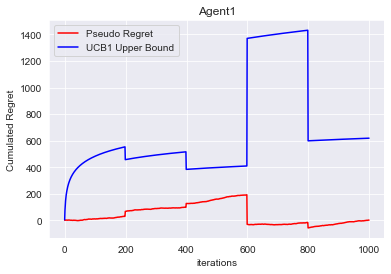

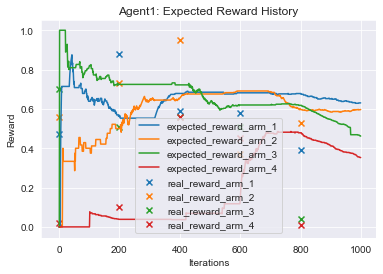

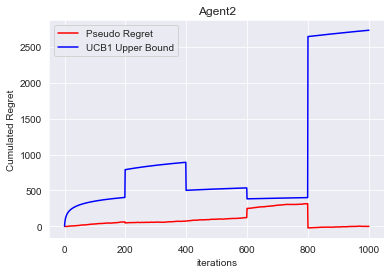

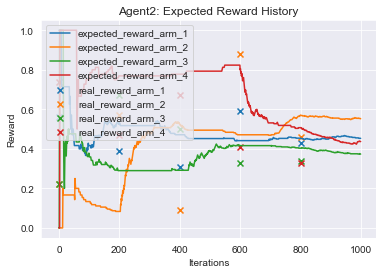

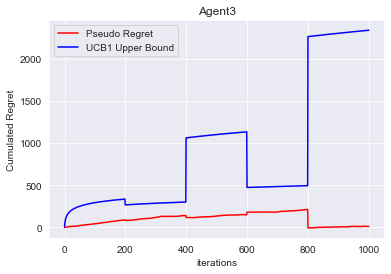

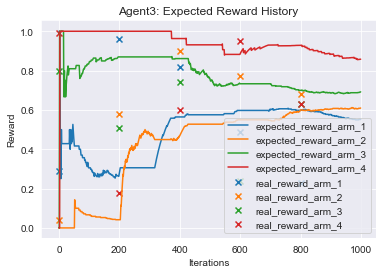

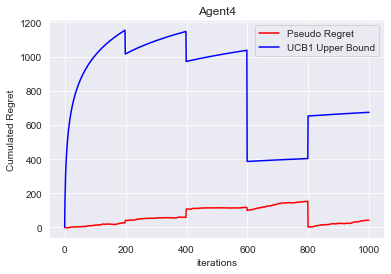

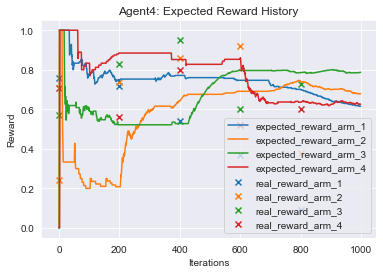

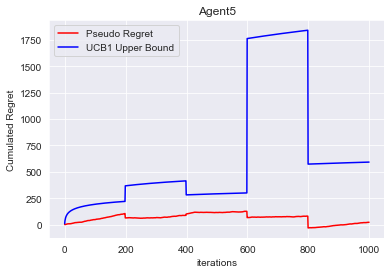

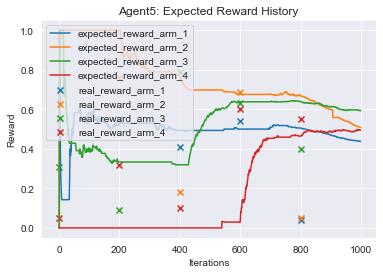

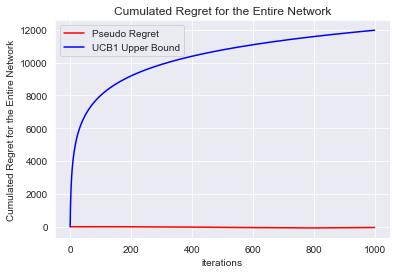

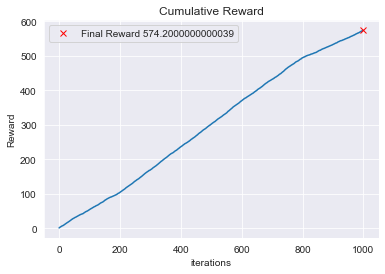

In [5]:
N_ITER = 1000
N_PERIOD = 200
DISTR = 'Binomial'
VARIATION = 'step'

multi = MultiAgentUCB(N_ITER,N_PERIOD,N_ARMS)

for agentname, rewardistr in rewardDistr.items():
    exec(str(multi.add_agent(Agent(agentname, N_ITER, DISTR, rewardistr, VARIATION))))
    
multi.start()

{}
[0.79, 0.69, 0.41, 0.86]
[0.9, 0.95, 0.12, 0.4]
[0.65, 0.06, 0.72, 0.34]
[0.69, 0.97, 0.57, 0.46]
[0.99, 0.96, 0.58, 0.07]
[0.6, 0.89, 0.94, 0.07]
[0.62, 0.14, 0.27, 0.62]
[0.71, 0.15, 0.35, 0.48]
[0.23, 0.66, 0.55, 0.74]
[0.89, 0.43, 0.51, 0.06]
[0.64, 0.11, 0.42, 0.78]
[0.13, 0.56, 0.93, 0.78]
[0.68, 0.78, 0.54, 0.34]
[0.25, 0.42, 0.01, 0.23]
[0.17, 0.44, 0.01, 0.38]
[0.18, 0.87, 0.16, 0.68]
[0.73, 0.5, 0.55, 0.28]
[0.62, 0.95, 0.81, 0.55]
[0.66, 0.04, 0.19, 0.07]
[0.64, 0.94, 0.17, 0.46]
[0.41, 0.12, 0.72, 0.57, 0.58, 0.94, 0.27, 0.35, 0.55, 0.51, 0.42, 0.93, 0.54, 0.01, 0.01, 0.16, 0.55, 0.81, 0.19, 0.17]


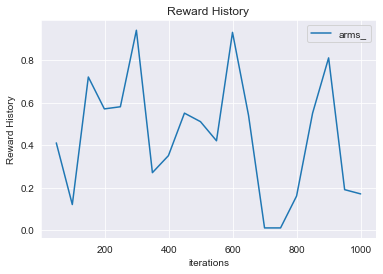

2.0
[[], [], [], []]
<class 'list'>


In [6]:
import numpy as np
rewardHistory = {}
#rewardHistory[0] = [0.2, 0.3, 0.7, 0.5]
#rewardHistory[99] = [0.8, 0.4, 0.7, 0.1]
#rewardHistory[199] = [1, 0.9, 0.1, 0.4]
print(rewardHistory)

def changereward(rewardHistory,t,n):
    reward = []
    for i in range(n):
        reward.append(np.random.randint(1,100)/100)
    rewardHistory[t] = reward
    return rewardHistory

for t in range(1000):
    if((t+1)%50 == 0):
        rewardHistory = changereward(rewardHistory,t,4)
        if(t > 0):
            print(rewardHistory[max(rewardHistory)])
key = [x for x in rewardHistory.keys()]
ar = [rewardHistory[i][2] for i in rewardHistory.keys()]
print(ar)

plt.plot(key, ar, label='arms_')
plt.ylabel('Reward History')
plt.xlabel('iterations')
plt.title('Reward History')
plt.legend()
plt.show()  
min(1,2)

print(np.mean([1,2,3]))

vuota = [[] for i in range(4)]
print(vuota)
print(type(vuota))

In [7]:
import numpy as np
weight = [0.8**i for i in range(4)]
print(weight[::-1])
print()
i=1
a = [1,2,3,4]
print(a[:2].count(i))
b = np.average(a,weights=weight[::-1])
print(b)

[0.5120000000000001, 0.6400000000000001, 0.8, 1.0]

1
2.7750677506775068
